In [1]:
# Python stdlib imports
import sys
import qgrid
import copy

# Module imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymatgen import Structure

# DFTman imports
sys.path.append('../../lib/')
import dftmanlib
from dftmanlib.pwscf import pwcalculation_helper, pseudo_helper, pseudo_table, PWOutput
from dftmanlib.pwscf.pwoutput import fast_patterns
from dftmanlib.job import SubmitJob, submitjob_statuses, submit_status
from dftmanlib.matproj import mpquery_helper
from dftmanlib.db import load_db

# Database imports
from tinydb import Query, where

# Jupyter setup
qgrid.enable()
%matplotlib notebook

# Load database
db = load_db()
table = db.table('SubmitJob')

# Pseudopotential constants
# PSEUDO_TABLE = '/data/tools/shared/dftman/pseudo_table.json'
# available pseudo families:
# ['SSSP_EFFICIENCY', 'SSSP_PRECISION', 'GBRV_LDA_US',
#  'GBRV_PBE_US', 'GBRV_PBEsol_US', 'DOJO_STANDARD_LDA_NC',
#  'DOJO_STANDARD_PBE_NC', 'DOJO_STANDARD_PBEsol_NC',
#  'DOJO_STRINGENT_LDA_NC', 'DOJO_STRINGENT_PBE_NC',
#  'DOJO_STRINGENT_PBAsol_NC',]
PSEUDO_FAMILY = 'SSSP_EFFICIENCY'

# Materials Project API Key
MP_API_KEY = '0WqdPfXxloze6T9N'

### Materials Project Query
The first step in any ab-initio calculation is to define the structure which should be simulated.
DFTman uses pymatgen `Structure` objects to handle crystal structures, so there are a few convenient ways to load structures into the programming environment:
* Manually input structure parameters by calling `pymatgen.Structure`
* Load structure from file using `pymatgen.io`
* Query for structures using the Materials Project API

Querying the Materials Project (MP) is often the simplest and most powerful way to load structures.
This process is further simplified by included class and function in DFTmanLib: `MPQuery` and `mpquery_helper`.
Queries have 3 required and 1 optional input:
* Query criteria which specify properties such as chemistry, and crystal structure
* Query parameters which define what information the query returns
* API key to authenticate with the Materials Project
* Optionally, a postprocessing function which uses Python code to further refine a query in ways which may be difficult or impossible through the standard interface

The available criteria and properties are described on the [Materials Project website](https://materialsproject.org/docs/api) and in their [Github repository](https://github.com/materialsproject/mapidoc/tree/master/materials/elasticity).

In [2]:
# Define the criteria for retrieving FCC Aluminum
criteria = {
    'elements': {'$in': ['Mo', 'S', 'Se', 'Te']},  # MoX2 TMDs
    # 'nsites': 3,  # three sites per cell
    'spacegroup.number': 194, 
    'e_above_hull': {'$lte': 0.0005}
}
# List properties to return
properties = ['band_gap', 'elasticity', 'spacegroup.number', 'spacegroup.symbol', 'e_above_hull']
# Define a postprocessing function to isolate TMD materials
def TMD_postprocess(materials):
    # Define desired sets of elements
    MoX2_sets = [{'Mo', 'S'}, {'Mo', 'Se'}, {'Mo', 'Te'}]
    MoX2_materials = []
    for material in materials:
        # Keep materials which have desired chemistry
        if set(material['elements']) in MoX2_sets:
            MoX2_materials.append(material)
    return MoX2_materials
# Create an MPQuery object using mpquery_helper
mp_query = mpquery_helper(criteria, properties, MP_API_KEY,
                          postprocess=TMD_postprocess)
mp_query.query()  # Run the query
mp_query.display()  # Display query results in a pretty table

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

### Configure Calculation
After loading an input structure into the programming environment, other parameters must be defined before running a calculation.
The availabile input parameters for the DFT package used here, Quantum Espresso PWscf, are listed in the [pw.x input documentation](https://www.quantum-espresso.org/Doc/INPUT_PW.html).

DFTmanLib uses `dftmanlib.pwscf` for interacting with pw.x's inputs and outputs.
Inputs are handled by `dftmanlib.pwscf.PWInput`, and outputs by `dftmanlib.pwscf.PWOutput`.
Entire calculations are represented by the object `dftmanlib.pwscf.PWCalculation`, which is a convenient wrapper around a pair of `PWInput` and `PWOutput` objects.
There are a lot of details to directly configuring `PWInput`, `PWOutput`, and `PWCalculation` objects, so some nice helper functions are provided, similar to `mpquery_helper` for `MPQuery` objects.
These are `dftmanlib.pwscf.pwinput_helper` and `dftmanlib.pwscf.pwcalculation_helper`. **However, almost always, `pwcalculation_helper` will be most convenient.**

Aside from calculation parameters, pseudopotentials are another critical input to DFT calculations, and they are selected by manually creating a `pseudos` dictionary or using `dftmanlib.pwscf.pseudo_helper`, which allows selecting a pseudopotential family from the collection of families provided by DFTman. These include [Standard Solid State Pseudopotentials (SSSP)](https://www.materialscloud.org/discover/sssp/table/efficiency), [Garrity-Bennett-Rabe-Vanderbilt (GBRV)](https://www.physics.rutgers.edu/gbrv/), [PseudoDojo (DOJO)](http://www.pseudo-dojo.org/) potentials with a variety of ultrasoft, norm-conserving; LDA, and GGA exchange-correlation functionals.

### Create, Store, and Run `PwCalculation`s using nanoHUB Submit
After loading an input structure, finding appropriate pseudopotentials, and configuring calculation parameters, all the necessary components are present to run a DFT calculation. The last step in this process is to create a `Job`, store it in the database, and run it. DFTman provides the following types of `Job`:
* `SubmitJob` is used on nanoHUB for remotely submitting to the nanoHUB cluster
* `PBSJob` can be used on any cluster running the a Torque PBS system
* `LocalJob` runs the calculation locally, e.g. in a nanoHUB workspace, on a cluster workspace, or on a local workstation

`Jobs` generally require the following inputs:
* A `Calculation` object which has the necessary properties described in `dftmanlib.base`, e.g. `PWCalculation`
* Which program to use. This is implemented differently in different types of `Job`.
* Resource parameters describing how many processors, nodes, and which queue to run on. These also vary slightly depending on the type of `Job`

The best way to figure out what specific inputs a type of `Job` needs is to run `help(JobClass)` where `JobClass` is the type of `Job` you're interested in (e.g. `help(SubmitJob)`)

`Jobs` should be automatically stored in the database when they are run, but often when their data are updated, they are **not** automatically updated in the database, to improve performance. Make sure you update jobs in the database by running `job.update()` at critical points in your code, like when you check a job's status or parse its output.

In [3]:
exp_lat = {
    'MoS2': {'a': 3.152,  # ICSD 38401 sg 194
             'c': 12.307},
    'MoSe2': {'a': 3.2891,  # ICSD 49800 sg 194
              'c': 12.9274},
    'Te2Mo': {'a': 3.5191,  # ICSD 15431 sg 194
              'c': 13.9644}
}
# TODO: determine appropriate kpoints density
# TODO: generate kpoints_grid from kpoints density

# Declare a pseudopotential family
pseudo_family = 'SSSP_EFFICIENCY'

# Declare cutoffs for MoX2 systems
# Mo potential requires highest ecutwfc
# S potential requires highest ecutrho
ecutwfc = 35.0  # Ry
ecutrho = ecutwfc * 8.0  # Ry
k_dist = 0.20  # 1/A

# Initialize a list for the calculations and another for document IDs
pw_calculations = []
doc_ids = []
for material in mp_query.result:
    # Iterate over different vdw corrections
    for vdw in ['none', 'grimme-d2', 'grimme-d3']:
        # Get the structure from the query results
        structure = material['structure']
        # Shrink the 'c' direction if using vdW corrections
        #     for faster calculations
        if vdw in ['grimme-d2', 'grimme-d3']:
            pymatgen_structure = Structure.from_dict(structure)
            c_strain = (exp_lat[material['pretty_formula']]['c'] -
                        pymatgen_structure.lattice.c) / pymatgen_structure.lattice.c
            pymatgen_structure.apply_strain([0, 0, c_strain])
            structure = pymatgen_structure.as_dict()
        # Save some parameters for comparison
        vdw_corr = vdw
        mp_alat = structure['lattice']['a']
        mp_clat = structure['lattice']['c']
        exp_alat = exp_lat[material['pretty_formula']]['a']
        exp_clat = exp_lat[material['pretty_formula']]['c']
        # Generate pseudopotentials dictionary
        pseudo = pseudo_helper(structure, pseudo_family)

        # Declare pw.x inputs
        pw_inputs = {
            # These are not traditional input cards,
            #     but this is the best way to provide
            #     them in DFTman
            'structure': structure,
            'pseudo': pseudo,

            # The following mirror traditional pw.x input
            #     cards
            'control': {
                'calculation': 'vc-relax',
                'verbosity': 'high',
                'disk_io': 'none',
                'tstress': True,
                'tprnfor': True
            },
            'system': {
                'ibrav': 0,
                'ecutwfc': ecutwfc,
                'ecutrho': ecutrho,
                'occupations': 'fixed',
                'vdw_corr': vdw,
            },
            'electrons': {
                'electron_maxstep': 500,
                'conv_thr': 1.0e-6
            },
            'ions': {

            },
            'cell': {
                'cell_factor': 4.0,
            },
            'kpoints_mode': 'automatic',
            'kpoints_grid': (int(round(structure['lattice']['a'] / k_dist)),
                             int(round(structure['lattice']['b'] / k_dist)),
                             int(round(structure['lattice']['c'] / k_dist))),
            'kpoints_shift': (0, 0, 0)
        }

        # Create a PWCalculation
        # additional inputs is a requirement for nanoHUB
        #     and should _always_ be equal to list(pseudo.values())
        #     for Quantum Espresso pw.x calculations
        pw_calculation = pwcalculation_helper(**pw_inputs, 
            additional_inputs=list(pseudo.values()), job_type='submit')
        # display(pw_calculation)
        
        submit_job = SubmitJob(calculation=pw_calculation,  # the calculation configured above
                               code='espresso-6.2.1_pw',  # QE v6.2.1 on nanoHUB
                               walltime='04:00:00',  # 2 hours max run time
                               ncpus=12,  # 8 processors requested
                               runname='DFTmanTMD',  # run name label in nanoHUB queue
                               # saving lattice params for comparison
                               metadata={'material_id': material['material_id'],
                                         'pretty_formula': material['pretty_formula'],
                                         'mp_alat': mp_alat,
                                         'mp_clat': mp_clat,
                                         'exp_alat': exp_alat,
                                         'exp_clat': exp_clat})

#         doc_id = submit_job.run()  # SubmitJob.run() returns the job's database document ID
#         doc_ids.append(doc_id)

### Loading Jobs from the Database
When `Job`s are run, they are automatically stored in the project database, located at `$DFTMAN_ROOT/projects/PROJECT DIRECTORY/db.tinydb`. DFTman uses the [TinyDB module](https://tinydb.readthedocs.io/en/latest/) to manage flat-file JSON-encoded document-based databases. DFTman implements a modified storage protocol based on the [monty module](http://guide.materialsvirtuallab.org/monty/)'s MSON encoder and decoder to automatically convert MSONable python objects to and from serializable python dicationaries. All of this is to say that you can directly store and retrieve Python objects like `Job`s which have `from_dict()` and `as_dict()` methods.

The database is organized by tables (think books in an excel document) which are named after the type of thing that they store. For example, the `'SubmitJob'` table stores `SubmitJob`s, and the `'PBSJob'` table stores `PBSJob`s. So, for a project using `SubmitJob`s, the way to load the appropriate database table is the following:
```
db = load_db()  # This is from dftmanlib.db
table = db.table('SubmitJob')
```

In practice, this is useful for storing input and output information for all `Job`s and `Workflow`s run using DFTman. A lot of information about how to get and query for database entries is listed in the [TinyDB documentation](https://tinydb.readthedocs.io/en/latest/), but the simplest way to load `Job`s into the programming environment from the database is to use the `TinyDB.table.get()` method with a `doc_id` (which is printed and returned whenever something new is added to the database).

Any time a project's notebook is shut down, all the variables and data stored in the python environment are lost. So, in order to check on the status of submitted `Job`s or load completed `Job`s and their output, they must be loaded from the database back into the python environment.

In [4]:
# This doc_id range contains the best TMD calculations
doc_ids = list(range(10, 19))
submit_jobs = [table.get(doc_id=doc_id) for doc_id in doc_ids]

### Watch Job Statuses
Once `Job`s are run on a remote resource like the nanoHUB cluster using `SubmitJob` or a research cluster using `PBSJob`, it's important to manually watch the status of the `Job` (or at least check it once it has completed) so DFTman knows when it's complete. Other managers use programs called daemons that run in the background to check the status of calculations, but DFTman cannot do this. There are generally three ways to check `Job` statuses:
* Queue status functions like `dftmanlib.job.submit_status()` provide information on **currently running** jobs and are the fastest status functions.
* Batch status functions like `dftmanlib.job.submitjob_statuses()` which act on a list of `Job` objects provide the status of all `Job`s which they are provided and are the slowest status functions.
* Individual status functions `Job.check_status()` which are provided by every `Job` class give the status of an individual `Job` and are useful when running few jobs or checking on specific statuses. 

Batch and individual status functions often also have the option to automatically update `Job`s in the database after checking their status, but this can be a *very* slow process and should only be done when necessary (i.e. when first checking job statuses and when all jobs are complete).

In [5]:
# Queue status
submit_status()

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [6]:
# Batch status
submitjob_statuses(submit_jobs, update_in_db=False)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

### Retrieve Output
When `Job`s complete successfully (and often when they complete unsuccessfully), their output can be parsed and brought into the programming environment using `job.parse_output()`. Behind the scenes, this function calls the `Job`'s `calculation.parse_output()` which in turn creates a new instance of the calculation's output class which is passed back up the chain. In the case of Quantum Espresso PWscf, this means creating a `PWOutput` object which provides many of the outputs in the pw.x stdout.

`job.parse_output()` always check's if `job.status['status'] == 'Complete'`, so it is important to ensure that `job.check_status()` is called before trying to parse output and that the job is up-to-date in the database.

To see the properties provided by `PWOutput`, use `help(PWOutput)` and look under Data Descriptors.
To list the entries in `PWOutput.data`, use `display(list(dftmanlib.pwscf.pwoutput.patterns.keys()))`

In [7]:
# Check status and parse output if Job is complete
# for submit_job in submit_jobs:
#     status = submit_job.check_status(update_in_db=False)
#     if submit_job.status['status'] == 'Complete':
#         output = submit_job.parse_output()

In [8]:
lat_results = {}
for pretty_formula in ['MoS2', 'MoSe2', 'Te2Mo']:
    job_query = Query()
    jobs = table.search(job_query.metadata.pretty_formula == pretty_formula)
    assert len(jobs) > 0
    if not lat_results.get(pretty_formula):
        meta = jobs[0]['metadata']
        lat_result = {
            'material_id': meta.get('material_id'),
            'pretty_formula': pretty_formula,
            'mp_alat': meta.get('mp_alat'),
            'mp_clat': meta.get('mp_clat'),
            'exp_alat': meta.get('exp_alat'),
            'exp_clat': meta.get('exp_clat'),
        }
        lat_results[pretty_formula] = lat_result
    lat_result = lat_results[pretty_formula]
    for job in jobs:
        vdw = job.input.sections['system'].get('vdw_corr')
        output_lattice = job.output.final_structure.lattice
        if vdw == 'none' or vdw is None:
            lat_result['dft_alat'] = output_lattice.a
            lat_result['dft_clat'] = output_lattice.c
        elif vdw == 'grimme-d2':
            lat_result['d2_alat'] = output_lattice.a
            lat_result['d2_clat'] = output_lattice.c
        elif vdw == 'grimme-d3':
            lat_result['d3_alat'] = output_lattice.a
            lat_result['d3_clat'] = output_lattice.c

lat_df = pd.DataFrame(lat_results.values())
display(lat_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

<IPython.core.display.Javascript object>


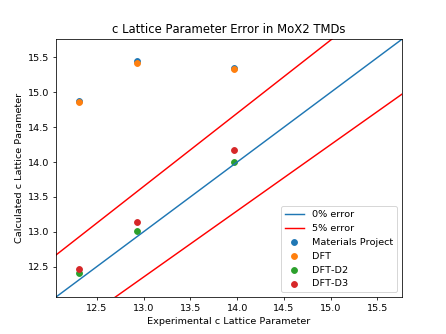

In [9]:
import matplotlib.pyplot as plt
%matplotlib notebook

axmin = lat_df['exp_clat'].min() * 0.98
axmax = lat_df['mp_clat'].max() * 1.02

plt.plot(np.linspace(axmin, axmax, 10),
         np.linspace(axmin, axmax, 10),
         label='0% error')
plt.plot(np.linspace(axmin, axmax, 10),
         np.linspace(axmin, axmax, 10)*1.05,
         label='5% error', color='red')
plt.plot(np.linspace(axmin, axmax, 10),
         np.linspace(axmin, axmax, 10)*0.95,
         color='red')

plt.scatter(lat_df['exp_clat'], lat_df['mp_clat'], label='Materials Project')
plt.scatter(lat_df['exp_clat'], lat_df['dft_clat'], label='DFT')
plt.scatter(lat_df['exp_clat'], lat_df['d2_clat'], label='DFT-D2')
plt.scatter(lat_df['exp_clat'], lat_df['d3_clat'], label='DFT-D3')

plt.xlim(axmin, axmax)
plt.ylim(axmin, axmax)

plt.xlabel('Experimental c Lattice Parameter')
plt.ylabel('Calculated c Lattice Parameter')
plt.title('c Lattice Parameter Error in MoX2 TMDs')
plt.legend()

plt.show()